# PyTorch and fastai implementations of SGD with momentum

In [1]:
from fastai2.vision.all import *
from fastai2.callback.fp16 import *

## Data

In [2]:
path = untar_data(URLs.IMAGENETTE)
Path.BASE_PATH = path
path.ls()

(#2) [Path('val'),Path('train')]

In [3]:
(path/'train').ls()

(#10) [Path('train/n03028079'),Path('train/n02102040'),Path('train/n03000684'),Path('train/n01440764'),Path('train/n03888257'),Path('train/n03425413'),Path('train/n02979186'),Path('train/n03394916'),Path('train/n03417042'),Path('train/n03445777')]

In [39]:
dataset_sizes = {x: len(get_image_files(path/x)) for x in ['train', 'val']}
dataset_sizes

{'train': 9469, 'val': 3925}

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                Normalize.from_stats(*imagenet_stats)])

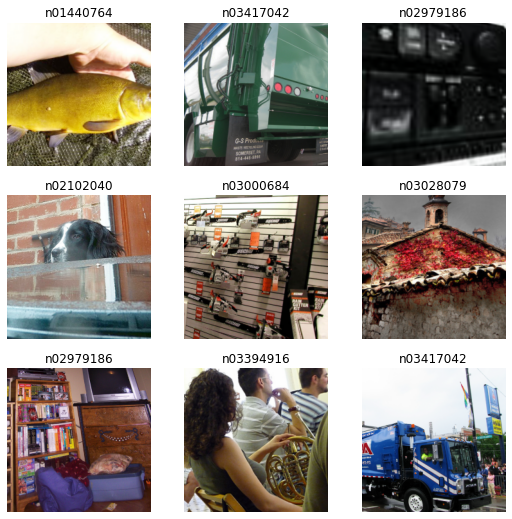

In [5]:
dls = dblock.dataloaders(path)
dls.show_batch()

### Model

In [6]:
model = xresnet50(n_out=dls.c)

## fastai implementation using optimizer callbacks

In [11]:
def first_moment(p, beta1, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': beta1*grad_avg + (1-beta2)*(p.grad.data)}

In [12]:
def debias(beta, ts):
    return 1 - beta**ts

In [13]:
def timestep(p, ts=0, **kwargs):
    ts += 1
    return {'ts': ts}

In [14]:
def mom_step(p, lr, beta1, ts, grad_avg, bias_correct=False, **kwargs):
    if bias_correct: 
        bc = debias(beta1, ts)
        lr /= bc
    
    p.data.add_(-lr, grad_avg)

In [15]:
opt_func = partial(Optimizer, cbs=[timestep, first_moment, mom_step], beta1=0.9)

### create and train learner

In [11]:
learn = Learner(dls, model, opt_func=opt_func, metrics=accuracy).to_fp16()

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.033113110810518265)

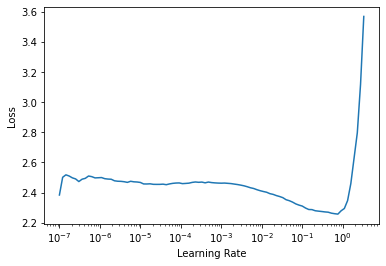

In [12]:
learn.lr_find()

In [13]:
lr=3e-2

In [ ]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.903607,1.765581,0.411720,01:28
1,1.592512,1.595371,0.474395,01:25
2,1.343039,1.438760,0.527389,01:26
3,1.246391,1.210805,0.620127,01:26
4,1.161158,1.254716,0.585987,01:26
5,1.079415,1.129434,0.642038,01:25
6,0.994749,0.990522,0.699363,01:26
7,0.964593,0.968362,0.698599,01:26


## PyTorch Implementation

In [34]:
class SGD_Momentum(torch.optim.Optimizer):
    def __init__(self, params, lr, beta, wd=0., bias_correct=False):
        defaults = dict(beta=beta, lr=lr, bias_correct=bias_correct)
        
        super(SGD_Momentum, self).__init__(params, defaults)
        
    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                beta = group['beta']
                lr, wd = group['lr'], group['wd']
                
                if p.grad is None: continue
                
                grad = p.grad.data + wd*p.data
                
                state = self.state(p)
                
                # ie. the first time we are updating the parameter
                if len(state) == 0:
                    state['grad_avg'] = torch.zeros_like(grad)
                    state['ts'] = 0
                
                grad_avg, ts = state['grad_avg'],state['ts']
                
                # update the state
                ts += 1
                grad_avg.mul_(beta).add_(1-beta, grad)
            
                if group['bias_correct']:
                    bc = 1 - beta**ts
                    lr /= bc
                
                # update the parameters
                p.data.add_(-lr, grad_avg)
                

### retrain model

In [35]:
from training_loop import train_model

In [36]:
model = xresnet50(n_out=dls.c)

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [38]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = SGD_Momentum(model.parameters(), 1e-2, beta=0.99)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = train_model(dls, model, criterion, optimizer, exp_lr_scheduler,
                    device, dataset_sizes, num_epochs=5)